In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import time
import random
def print_np(x):
    print ("Type is %s" % (type(x)))
    print ("Shape is %s" % (x.shape,))
#     print ("Values are: \n%s" % (x))

In [2]:
import os
import sys
sys.path.append('../')

In [3]:
from model import UnicycleModel
from cost import UnicycleCost
from constraints import UnicycleConstraints
from scipy.integrate import solve_ivp
from matplotlib.patches import Ellipse
from utils.utils_alg import get_neighbor_vec,get_K_discrete
from utils.utils_plot import plot_traj,plot_traj_set,plot_state_input
from Single_PTR import Single_PTR
from PTR import PTR
from utils.utils_alg import get_sample_eta_w,propagate_model
import cvxpy as cvx
from scipy.integrate import solve_ivp
from EstimatingLipschitz import Lipschitz
from LMI import Q_update

In [4]:
ix = 3
iu = 2
iw = 2
iq = 2
ip = 2
N = 30
tf = 3
delT = tf/N

In [5]:
# time-invariant matrices
C = np.array([[0,0,1],[0,0,0]])
D = np.array([[0,0],[1,0]])
E = np.array([[1,0],[0,1],[0,0]])
G = np.zeros((iq,iw))

## obstacle setting

In [6]:
def get_H_obs(rx,ry) :
    return np.diag([1/rx,1/ry])
# obstacle
c_list = []
H_list = []
c1 = [1,2]
H1 = get_H_obs(0.75,1.5)
c_list.append(c1)
H_list.append(H1)
c2 = [4,3]
H2 = get_H_obs(0.75,1.5)
c_list.append(c2)
H_list.append(H2)

## initial and final conditions 

In [7]:
xi = np.zeros(3)
xi[0] = 0.0
xi[1] = 0.0 
xi[2] = 0

xf = np.zeros(3)
xf[0] = 5.0
xf[1] = 5.0
xf[2] = 0

Qini = np.diag([0.4**2,0.4**2,np.deg2rad(20)**2])
Qf = np.diag([0.5**2,0.5**2,np.deg2rad(20)**2])*1.5



myModel = UnicycleModel.unicycle('Hello',ix,iu,iw,'numeric_central')
myCost = UnicycleCost.unicycle('Hello',ix,iu,N)
myConst = UnicycleConstraints.UnicycleConstraints('Hello',ix,iu)
myConst.set_obstacle(c_list,H_list)

x0 = np.zeros((N+1,ix))
for i in range(N+1) :
    x0[i] = (N-i)/N * xi + i/N * xf
u0 = np.zeros((N+1,iu))

In [8]:
A,B,s,z,x_prop_n = myModel.diff_discrete_zoh(x0[0:N,:],u0[0:N,:],delT,tf) 
S = np.eye(ix)
R = 1*np.eye(iu)
K0 = get_K_discrete(A,B,S,R,S,N,ix,iu)
Q0 = np.tile(np.diag([0.35**2,0.35**2,np.deg2rad(10)**2]),(N+1,1,1))
Y0 = K0@Q0[:N]
betahat = np.ones(N+1)

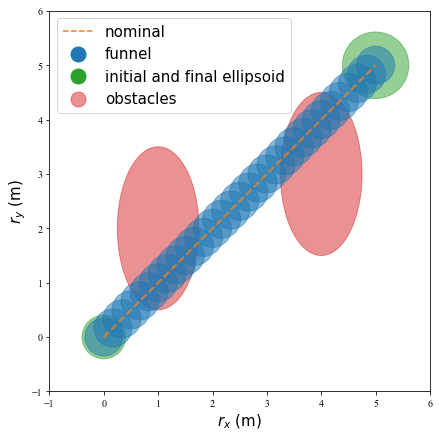

In [9]:
plt.figure(0,figsize=(7,7))
plot_traj_set(x0,u0,c_list,H_list,Q0,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt)

## choose sample points

In [10]:
num_sample = 100
zs_sample = [] # sample in unit sphere will be projected to ellipse (Q_k)
zw_sample = [] 
# random
# for i in range(num_sample) :
#     z = np.random.randn(ix)
#     zs = z / np.linalg.norm(z)
#     zs_sample.append(zs)
    
#     z = np.random.randn(iw)
#     zw = z / np.linalg.norm(z)
#     zw_sample.append(zw)
    
# uniformly fixed
for i in np.linspace(-1.0, 1.0, num=5) :
    for j in np.linspace(-1.0, 1.0, num=5) :
        for k in np.linspace(-1.0, 1.0, num=4) :
            z = np.array([i,j,k])
            zs = z / np.linalg.norm(z)
            zs_sample.append(zs)
for i in np.linspace(-1.0, 1.0, num=10) :
    for j in np.linspace(-1.0, 1.0, num=10) :
        z = np.array([i,j])
        zw = z / np.linalg.norm(z)
        zw_sample.append(zw)

## run

In [11]:
history = []
total_iter = 40
tol_funnel = 1e-3
tol_traj = 1e-4

print("STEP 0 : Start")
for idx_iter in range(total_iter) :
    print("====================================================")
    if idx_iter == 0 :
        xhat,uhat,Qhat,Yhat,Khat = x0,u0,Q0,Y0,K0
    
    print("STEP 1 : Nominal trajectory update")
    traj_solver= Single_PTR('unicycle',N,tf,1,myModel,myCost,myConst,
              w_c=1,w_vc=1e3,w_tr=1e1,tol_vc=1e-6,tol_tr=1e-4,verbosity=False)
    _,_,xnew,unew,total_num_iter,flag_boundary,traj_cost,traj_vc,traj_tr = traj_solver.run(xhat,uhat,xi,xf,Qhat,Khat)

    # discretization
    A,B,F,s,z,x_prop_n = myModel.diff_discrete_zoh_noise(xnew,unew,np.zeros((N,iw)),delT,tf) 
    sz = tf*s + z
    # propagation
    xprop,_ = traj_solver.forward_multiple(xnew,unew)
    e_prop = np.linalg.norm(xprop - xnew[1:],axis=1)
    
    print("STEP 2 : Lipschitz constant estimation")
    myM = Lipschitz(ix,iu,iq,ip,iw,N)
    myM.initialize(xnew,unew,xprop,Qhat,Khat,A,B,C,D,E,F,G,myModel,zs_sample,zw_sample)
    gamma = myM.update_lipschitz_norm(myModel,delT)
#     gamma = myM.update_lipschitz_parallel(myModel,delT)
#     print("mean of gamma",np.mean(gamma,0),"max of gamma",np.max(gamma,0),"var of gamma",np.var(gamma,0))

    print("STEP 3 : Funnel update via SDP")
    funl_solver = Q_update(ix,iu,iq,ip,iw,N,delT,myCost.S,myCost.R,w_tr=1e-1)
    funl_solver.initialize(xnew,unew,e_prop*0,A,B,C,D,E,F,G)
    alpha = 0.99
    Qnew,Knew,Ynew,status,funl_cost = funl_solver.solve(alpha,gamma,Qini,Qf,Qhat,Yhat)
#     print("LMI status:" + status)
    
    print("STEP 4 : update beta for invariance")
    betanew = funl_solver.update_beta(Qnew,Knew,gamma,alpha)
    for i in range(N+1) :
        Qnew[i] = Qnew[i] * betanew[i]
#     print("beta max {:}".format(np.max(betanew)))
    
    # plot the trajectory
    plt.figure(1,figsize=(7,7))
    plot_traj_set(xnew,unew,c_list,H_list,Qnew,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt)
    plt.title(str(idx_iter+1)+' iterations',fontsize=15)
#     plt.show()
    plt.rcParams["font.family"] = "Times New Roman"
    plt.savefig('../images/iteration/'+str(idx_iter)+'.png',dpi=1000)
    plt.close()

    # measure the difference
    xdiff = np.sum(np.linalg.norm(xhat-xnew,axis=1)**2)
    udiff = np.sum(np.linalg.norm(uhat-unew,axis=1)**2)
    Qdiff = np.sum(np.array([np.linalg.norm(Qhat[i]-Qnew[i],ord='fro') for i in range(N+1)])**2)
    Kdiff = np.sum(np.array([np.linalg.norm(Khat[i]-Knew[i],ord='fro') for i in range(N)])**2)
    Ydiff = np.sum(np.array([np.linalg.norm(Yhat[i]-Ynew[i],ord='fro') for i in range(N)])**2)
    betadiff = np.linalg.norm(betanew-betahat)
    
    # update trajectory
    xhat = xnew
    uhat = unew
    Qhat = Qnew
    Khat = Knew
    Yhat = Ynew
    betahat = betanew
    
    # save trajectory
    traj = {}
    traj['x'] = xhat
    traj['u'] = uhat
    traj['Q'] = Qhat
    traj['Y'] = Yhat
    traj['K'] = Khat
    traj['gamma'] = gamma
    traj['traj_diff'] = xdiff + udiff
    traj['funl_diff'] = Qdiff + Kdiff
    traj['beta_diff'] = betadiff
    history.append(traj)
    
    print("iter| traj_cost | funl_cost |   vc   |   Delta_T   |   Delta_F   |e_prop|mean_gamma|max_beta")
    print("%4d %11.3f %11.3f %8.3g %13.3g %13.3g %6.3f %10.3f %8.3g" % ( idx_iter+1,
                        traj_cost,funl_cost,traj_vc,
                        traj['traj_diff'],traj['funl_diff'],
                        np.max(e_prop),
                        np.mean(gamma,0),
                        np.max(betanew),
                        ))

    
    
    if traj['traj_diff'] < tol_traj and traj['funl_diff'] < tol_funnel :
        print("SUCCESS")
        break
    else :
        print("Accept the step")
    

STEP 0 : Start
STEP 1 : Nominal trajectory update
STEP 2 : Lipschitz constant estimation
STEP 3 : Funnel update via SDP
STEP 4 : update beta for invariance
iter| traj_cost | funl_cost |   vc   |   Delta_T   |   Delta_F   |e_prop|mean_gamma|max_beta
   1      86.009      22.868        5           114      1.08e+03  1.874      0.016        1
Accept the step
STEP 1 : Nominal trajectory update
STEP 2 : Lipschitz constant estimation
STEP 3 : Funnel update via SDP
STEP 4 : update beta for invariance
iter| traj_cost | funl_cost |   vc   |   Delta_T   |   Delta_F   |e_prop|mean_gamma|max_beta
   2     178.637      38.641    0.232           157      1.44e+03  0.231      0.028        1
Accept the step
STEP 1 : Nominal trajectory update
STEP 2 : Lipschitz constant estimation
STEP 3 : Funnel update via SDP
STEP 4 : update beta for invariance
iter| traj_cost | funl_cost |   vc   |   Delta_T   |   Delta_F   |e_prop|mean_gamma|max_beta
   3     217.715      20.235 1.18e-11          96.1           718

In [12]:
traj_diff_list = [history[i]['traj_diff'] for i in range(idx_iter+1)]
funl_diff_list = [history[i]['funl_diff'] for i in range(idx_iter+1)]

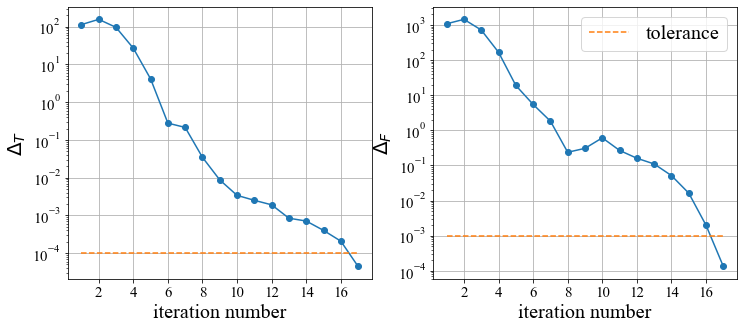

In [13]:
i_index = np.array([i+1 for i in range(idx_iter+1)])
fS = 20
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(i_index,traj_diff_list,'o-')
plt.plot(i_index,i_index*0+tol_traj,'--')
plt.xlabel('iteration number',fontsize=fS,fontname='Times New Roman')
plt.ylabel(r'$\Delta_T$',fontsize=fS,fontname='Times New Roman')
plt.yscale('log')
# plt.ylim([10**(-6), 10**(4)])
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(fontsize=fS)
plt.subplot(122)
plt.plot(i_index,funl_diff_list,'o-')
plt.plot(i_index,i_index*0+tol_funnel,'--',label="tolerance")
plt.xlabel('iteration number',fontsize=fS,fontname='Times New Roman')
plt.ylabel(r'$\Delta_F$',fontsize=fS,fontname='Times New Roman')
plt.yscale('log')
# plt.ylim([10**(-6), 10**(4)])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.legend(fontsize=fS)
plt.grid(True)
plt.savefig('../images/convergence_result.pdf')

# Evaluate the generated traj and funl

In [14]:
from utils.utils_alg import forward_full_with_K,get_sample_trajectory
import scipy

In [15]:
xbar = history[-1]['x']
ubar = history[-1]['u']
Qbar = history[-1]['Q']
Ybar = history[-1]['Y']
Kbar = history[-1]['K']

# Obtain nominal traj without the funnel

In [16]:
traj_solver= PTR('unicycle',N,tf,30,myModel,myCost,myConst,
              w_c=1,w_vc=1e3,w_tr=1e1,tol_vc=1e-6,tol_tr=1e-4,verbosity=True)
_,_,xnom,unom,total_num_iter,flag_boundary,_,_,_ = traj_solver.run(x0,u0,xi,xf)


iteration   total_cost        cost        ||vc||     ||tr||       reduction   w_tr        bounary
1           5918.533          83.340      5           83.5        -4.92e+03   10.000      0( 5)
2           915.754           128.182     2.88e-09    78.8        5e+03       10.000      0(2.28)
3           266.635           196.911     2.53e-10    6.97        649         10.000      0(0.732)
4           218.399           206.527     2.39e-09    1.19        48.2        10.000      0(0.0864)
5           209.577           208.977     3.74e-10    0.06        8.82        10.000      0(0.00239)
6           208.509           208.248     4.5e-10     0.0262      1.07        10.000      1(0.000376)
7           207.905           207.791     9.81e-10    0.0114      0.604       10.000      1(0.000135)
8           207.724           207.702     1.28e-09    0.00221     0.181       10.000      1(5.41e-05)
9           207.693           207.687     1.09e-09    0.0006      0.0305      10.000      1(1.48e-05)


# Sample from initial set

In [17]:
x0_sample = []
num_sample = 100
idx = 0
for i in range(num_sample) :
    z = np.random.randn(ix)
    z = z / np.linalg.norm(z)
    x_s = xbar[idx] + scipy.linalg.sqrtm(Qbar[idx])@z
    x0_sample.append(x_s)
    



In [18]:
tsam,xsam,usam,wsam = get_sample_trajectory(xi,x0_sample,xbar,ubar,Qbar,Ybar,myModel,N,ix,iu,iw,delT,flag_noise=True,discrete=True)


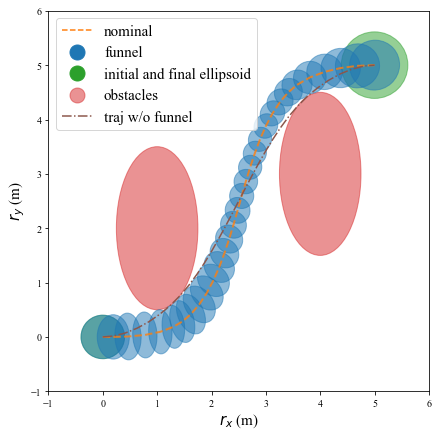

In [19]:
fS = 15
plt.figure(0,figsize=(7,7))
plot_traj_set(xbar,ubar,c_list,H_list,Qbar,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt)
plt.plot(xnom[:,0],xnom[:,1],'-.',color='tab:brown',label='traj w/o funnel')
plt.legend(fontsize=fS)
plt.rcParams["font.family"] = "Times New Roman"

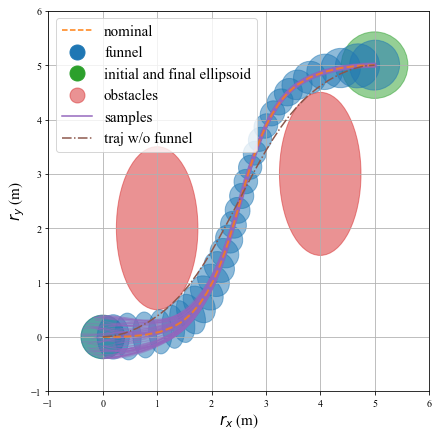

In [20]:
fS = 15
plt.figure(0,figsize=(7,7))
for xsam_e in xsam :
    plt.plot(xsam_e[:,0], xsam_e[:,1],'-',markersize=4.0, linewidth=1.0,alpha=0.4,color='tab:purple')
plot_traj_set(xbar,ubar,c_list,H_list,Qbar,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,flag_label=True)
plt.plot(1e3,1e3,'-',color='tab:purple',label='samples')
plt.plot(xnom[:,0],xnom[:,1],'-.',color='tab:brown',label='traj w/o funnel')
plt.legend(fontsize=fS)
plt.grid(True)
plt.rcParams["font.family"] = "Times New Roman"
plt.savefig('../images/traj_result.pdf')

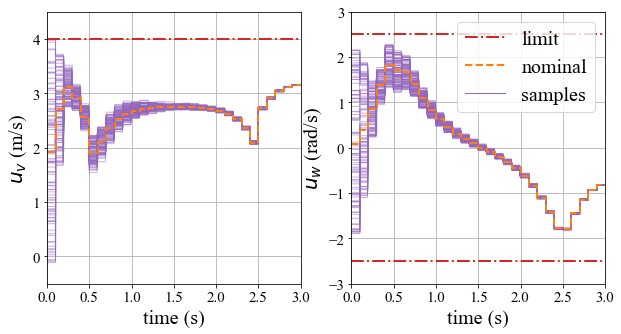

In [21]:
fS = 20
plt.figure(0,figsize=(10,5))
alpha = 0.5
t_index = np.array(range(N+1))*delT
for i in range(num_sample) :
    tsam_e = tsam[i]
    xsam_e = xsam[i]
    usam_e = usam[i]
#     plot_state_input(tsam_e,xsam_e,usam_e,None,None,N,delT,alpha,plt,flag_step=False)

    plt.subplot(121)
    plt.plot(tsam_e, usam_e[:,0],color='tab:purple',alpha=alpha,linewidth=1.0)
    plt.subplot(122)
    plt.plot(tsam_e, usam_e[:,1],color='tab:purple',alpha=alpha,linewidth=1.0)
plt.subplot(121)
plt.plot(tsam_e, usam_e[:,0]*0+myConst.vmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
plt.step(t_index, [*ubar[:N,0],ubar[N-1,0]],'--',color='tab:orange',alpha=1.0,where='post',linewidth=2.0,label='nominal')
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$u_v$ (m/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -0.5, 4.5])
plt.grid(True)
plt.subplot(122)
plt.plot(tsam_e, usam_e[:,1]*0+myConst.wmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
plt.plot(tsam_e, usam_e[:,1]*0+myConst.wmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
plt.step(t_index, [*ubar[:N,1],ubar[N-1,1]],'--',color='tab:orange',alpha=1.0,where='post',linewidth=2.0,label='nominal')
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$u_w$ (rad/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -3, 3])
plt.legend(fontsize=fS)
plt.rcParams["font.family"] = "Times New Roman"
plt.grid(True)
plt.savefig('../images/input_result.pdf')


In [22]:
# fS = 20
# plt.figure(0,figsize=(10,5))
# alpha = 0.5
# t_index = np.array(range(N+1))*delT
# for i in range(num_sample) :
#     tsam_e = tsam[i]
#     xsam_e = xsam[i]
#     wsam_e = wsam[i]
# #     plot_state_input(tsam_e,xsam_e,usam_e,None,None,N,delT,alpha,plt,flag_step=False)
#     plt.subplot(121)
#     plt.plot(tsam_e, wsam_e[:,0],color='tab:purple',alpha=alpha,linewidth=1.0)
#     plt.subplot(122)
#     plt.plot(tsam_e, wsam_e[:,1],color='tab:purple',alpha=alpha,linewidth=1.0)
# plt.subplot(121)
# plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
# plt.xlabel('time (s)', fontsize = fS)
# plt.ylabel('w1 (m)', fontsize = fS)
# plt.axis([0.0, tf, -2, 2])
# plt.subplot(122)
# plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
# plt.xlabel('time (s)', fontsize = fS)
# plt.ylabel('w2 (m)', fontsize = fS)
# plt.axis([0.0, tf, -2, 2])
# plt.legend(fontsize=fS)
# plt.rcParams["font.family"] = "Times New Roman"
# # plt.savefig('../images/disturbance.pdf')